In [679]:
library(RBGL)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
#library(tibble)
library("rjson")

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

In [680]:
config <- fromJSON(file = "config.json")

In [681]:
directory <- config$output_dir
dims <- config$dims[[1]]
sample_sizes <- config$sample_sizes[[1]]
replicates <- config$replicates$start:config$replicates$end
dag_avparents <-config$av_parents[[1]]

In [682]:
sample_sizes

[1] 100

In [683]:
rjson::fromJSON('[[[1,0], [0,1]]]', simplify = TRUE)


[[1]]
[[1]][[1]]
[1] 1 0

[[1]][[2]]
[1] 0 1

In [684]:
config

$output_dir
[1] "simresults"

$replicates
$replicates$start
[1] 1

$replicates$end
[1] 2


$sample_sizes
[1] 100

$av_parents
[1] 2

$dims
[1] 80

$score
$score$bdecatpar
$score$bdecatpar$chi
[1] 1

$score$bdecatpar$edgepf
[1] 1



$blip
$blip$plot_legend
[1] "blip"

$blip$scorer.method
[1] "is"

$blip$solver.method
[1] "winasobs"

$blip$indeg
[1] 80

$blip$time
[1] 10

$blip$allocated
[1] 80

$blip$scorefunction
[1] "bdeu"

$blip$alpha
[1] 1

$blip$cores
[1] 1

$blip$verbose
[1] 0


$gobnilp
$gobnilp$plot_legend
[1] "gobnilp"

$gobnilp$plot
[1] FALSE

$gobnilp$palim
[1] 2


$fges
$fges$plot_legend
[1] "fges"

$fges$faithfulnessAssumed
[1] 1


$pcalg
$pcalg$plot_legend
[1] "pcalg"

$pcalg$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45


$mmhc
$mmhc$plot_legend
[1] "mmhc"

$mmhc$restrict.args
$mmhc$restrict.args$alpha
[1] 0.01 0.05 0.10 0.20 0.35 0.45



$itsearch_map
$itsearch_map$plot_legend
[1] "itmap"

$itsearch_map$optional
$itsearch_map$optional$MAP
[1] 1

$itsearch_map$optional$plus1it
NULL

$itsearch_map$optional$posterior
NULL


$itsearch_map$score_params
$itsearch_map$score_params$bdecatpar
$itsearch_map$score_params$bdecatpar$chi
[1] 1

$itsearch_map$score_params$bdecatpar$edgepf
[1] 1




$itsearch_sample
$itsearch_sample$plot_legend
[1] "itsample"

$itsearch_sample$optional
$itsearch_sample$optional$MAP
[1] 0

$itsearch_sample$optional$plus1it
[1] 6

$itsearch_sample$optional$posterior
[1] 0.5


$itsearch_sample$score_params
$itsearch_sample$score_params$bdecatpar
$itsearch_sample$score_params$bdecatpar$chi
[1] 1

$itsearch_sample$score_params$bdecatpar$edgepf
[1] 1




$ordermcmc_map
$ordermcmc_map$plot_legend
[1] "omcmc_itmap"

$ordermcmc_map$startspace
[1] "itsearch_map"

$ordermcmc_map$optional
$ordermcmc_map$optional$plus1
[1] TRUE


$ordermcmc_map$score_params
$ordermcmc_map$score_params$bdepar
$ordermcmc_map$score_params$bdepar$chi
[1] 1

$ordermcmc_map$score_params$bdepar$edgepf
[1] 1



$ordermcmc_map$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20


$ordermcmc_sample
$ordermcmc_sample$plot_legend
[1] "omcmc_itsample"

$ordermcmc_sample$startspace
[1] "itsearch_sample"

$ordermcmc_sample$optional
$ordermcmc_sample$optional$plus1
[1] TRUE


$ordermcmc_sample$threshold
 [1] 0.99 0.95 0.90 0.80 0.70 0.60 0.50 0.40 0.30 0.20

$ordermcmc_sample$score_params
$ordermcmc_sample$score_params$bdepar
$ordermcmc_sample$score_params$bdepar$chi
[1] 1

$ordermcmc_sample$score_params$bdepar$edgepf
[1] 1

### Order MCMC

In [685]:
filenames <- list.files(pattern = "^(res_orderMCMC)", path = directory)
ROCdf_order_mcmc_itsearch_map <- data.frame()
ROCdf_order_mcmc_itsearch_sample <- data.frame()
ROCdf_order_mcmc <- data.frame()

tmpdf <- NULL
for (filename in filenames) {
    tmpdf <- read.csv(file.path(directory, filename))
    
#    tmpdf$algorithm <- apply(tmpdf["itsearch_MAP"], 1, 
# function(a){
#    if(a==TRUE){ 
#        return("order_mcmc_itsearch_map")
#     }else {
#        return("order_mcmc_itsearch_sample")
#      }
#  })   
#     tmpdf$itsearch_plus1it <- apply(tmpdf["itsearch_plus1it"], 1, 
#         function(a){
#    if(a=="None"){ 
#        return(NA)
#     }else {
#        return(a)
#     }
#     })  
    ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}
print(tmpdf)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

        TPR FPRn  logscore SHD avparents replicate algorithm dim sample_size
1 0.1111111    0 -4840.775  74         2         2 orderMCMC  80         100
  map blacklist startorder scoretable moveprobs iterations stepwise alpha cpdag
1  NA        NA         NA         NA        NA         NA       NA  0.05 False
  gamma hardlimit chainout scoreout verbose threshold startspace_method
1     1        15     True    False   False      0.99          itsearch
              startspace_params  time         legend
1 map_0_plus1it_6_posterior_0.5 22.32 omcmc_itsample


In [688]:
ROCdf_order_mcmc

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,map,⋯,gamma,hardlimit,chainout,scoreout,verbose,threshold,startspace_method,startspace_params,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<lgl>,⋯,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<chr>
0.75,0.15,-1044.7933,18,2,1,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1_plus1it_None_posterior_None,5.62,omcmc_itmap
0.90,0.40,-913.8295,16,2,2,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_1_plus1it_None_posterior_None,5.81,omcmc_itmap
0.75,0.15,-1043.8015,19,2,1,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0_plus1it_6_posterior_0.5,5.11,omcmc_itsample
0.90,0.30,-922.1578,16,2,2,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.2,itsearch,map_0_plus1it_6_posterior_0.5,5.91,omcmc_itsample
0.75,0.05,-1059.2191,15,2,1,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1_plus1it_None_posterior_None,5.62,omcmc_itmap
0.90,0.20,-957.5505,14,2,2,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_1_plus1it_None_posterior_None,5.81,omcmc_itmap
0.75,0.05,-1064.3929,15,2,1,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0_plus1it_6_posterior_0.5,5.11,omcmc_itsample
0.90,0.20,-934.7788,14,2,2,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.3,itsearch,map_0_plus1it_6_posterior_0.5,5.91,omcmc_itsample
0.75,0.00,-1103.4635,16,2,1,orderMCMC,20,100,NA,⋯,1,15,True,False,False,0.4,itsearch,map_1_plus1it_None_posterior_None,5.62,omcmc_itmap


In [689]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>%
                    filter(replicate %in% replicates) %>%
                    # filter(is.na(itsearch_plus1it) | (itsearch_plus1it %in% config$itsearch_sample$optional$plus1it)) %>%
                    group_by(legend, threshold, sample_size, dim, avparents) %>% 
                    summarise(SHD_mean = mean(SHD),
                              TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time_mean = mean(time),
                              logscore_mean = mean(logscore),
                              N = n()) #%>%
                    #filter(N %in% length(replicates))

In [692]:
labels <- apply(sumROC_order_mcmc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sumROC_order_mcmc["labels"] <- labels

In [693]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,80,2,95.5,0.78888889,0.78888889,0.59645062,0.77888889,0.79888889,26.110,-3678.604,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.30,100,80,2,80.5,0.77013889,0.77013889,0.43479938,0.76326389,0.77701389,26.110,-3742.729,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.40,100,80,2,72.5,0.75138889,0.75138889,0.34174383,0.72763889,0.77513889,26.110,-3863.963,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.50,100,80,2,63.5,0.73287037,0.73287037,0.26111111,0.72578704,0.73995370,26.110,-3980.576,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.60,100,80,2,62.5,0.63317901,0.63317901,0.19290123,0.58081790,0.68554012,26.110,-4087.473,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.70,100,80,2,63.5,0.50887346,0.50887346,0.13695988,0.44463735,0.57310957,26.110,-4223.378,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.80,100,80,2,67.0,0.42808642,0.42808642,0.11820988,0.35780864,0.49836420,26.110,-4307.178,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.90,100,80,2,66.5,0.32260802,0.32260802,0.07476852,0.26851080,0.37670525,26.110,-4484.674,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.95,100,80,2,71.0,0.22962963,0.22962963,0.03734568,0.20296296,0.25629630,26.110,-4598.960,2,"p=80, n=100, avparents=2, N=2"


### Iterative MCMC

In [694]:
filenames <- list.files(pattern = "^(res_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  # Convert "None" string to NA
    tmpdf["plus1it"] <- na_if(tmpdf["plus1it"], "None")
   tmpdf["posterior"] <- na_if(tmpdf["posterior"], "None")
    ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
  
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and fac

In [695]:
ROCdf_itsearch

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,plus1it,⋯,mergetype,addspace,scoretable,startorder,accum,score_type,bdecatpar_chi,bdecatpar_edgepf,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,⋯,<fct>,<lgl>,<lgl>,<lgl>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>
0.8500000,0.2000000,-1155.7233,14,2,1,itsearch,20,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,21.34,itsample
0.5000000,0.1500000,-994.8069,19,2,2,itsearch,20,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,19.96,itsample
0.8500000,0.2000000,-1059.8358,20,2,1,itsearch,20,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,9.62,itmap
0.9000000,0.3000000,-911.4717,18,2,2,itsearch,20,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,13.13,itmap
0.6600000,0.4000000,-2507.5965,53,2,1,itsearch,50,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,32.95,itsample
0.6600000,0.3000000,-2508.8129,51,2,2,itsearch,50,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,32.95,itsample
0.7600000,0.6200000,-2335.0418,72,2,1,itsearch,50,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,23.61,itmap
0.8400000,0.5200000,-2257.7177,56,2,2,itsearch,50,100,NA,⋯,skeleton,NA,NA,NA,False,bde,1,1,18.10,itmap
0.6250000,0.2250000,-3891.9464,78,2,1,itsearch,80,100,6,⋯,skeleton,NA,NA,NA,False,bde,1,1,103.48,itsample


In [696]:
#ROCdf_itsearch$algorithm <- apply(ROCdf_itsearch["MAP"], 1, 
# function(a){
#    if(a==TRUE){ 
#        return("itsearch_map")
#     }else {
#        return("itsearch_sample")
#      }
#  })                                          

In [697]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%
                filter(is.na(plus1it) | (plus1it %in% config$itsearch_sample$optional$plus1it)) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                           time_mean = mean(time),
                         #  it_mean = mean(it),
                          N = n()) #%>%
                    #filter(N %in% length(replicates))0

labels <- apply(sum_roc_itsearch, 1, function(row) {
    paste("p=",row["dim"],", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_itsearch["labels"] <- labels 

In [698]:
labels

[1] "p=80, n=100, avparents=2, N=2" "p=80, n=100, avparents=2, N=2"

In [699]:
sum_roc_itsearch

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,time_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
itmap,100,80,2,99.5,0.7888889,0.7888889,0.5841049,0.7788889,0.7988889,-3595.179,62.245,2,"p=80, n=100, avparents=2, N=2"
itsample,100,80,2,73.5,0.6087963,0.6087963,0.2050926,0.5942130,0.6233796,-3873.935,118.785,2,"p=80, n=100, avparents=2, N=2"


### PC algorithm

In [700]:
filenames <- list.files(pattern = "^(res_pcalg)", path = directory)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [701]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                 filter(sample_size %in% sample_sizes) %>%         
                 filter(avparents %in% dag_avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise(
                          SHD_mean = mean(SHD),
                          TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          time_mean = mean(time),
                          N = n())# %>% ungroup() %>%
#                 filter(N %in% replicates)
labels <- apply(sum_roc_pcalg, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_pcalg["labels"] <- labels 

In [702]:
sum_roc_pcalg

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
pcalg,0.01,100,80,2,60.5,0.5155864,0.5155864,0.01875000,0.5071142,0.5240586,6.735,2,"p=80, n=100, avparents=2, N=2"
pcalg,0.05,100,80,2,59.5,0.5962963,0.5962963,0.06851852,0.5929630,0.5996296,8.370,2,"p=80, n=100, avparents=2, N=2"
pcalg,0.10,100,80,2,64.5,0.6337191,0.6337191,0.13641975,0.6078164,0.6596219,10.065,2,"p=80, n=100, avparents=2, N=2"
pcalg,0.20,100,80,2,69.0,0.6212963,0.6212963,0.20516975,0.5954630,0.6471296,18.170,2,"p=80, n=100, avparents=2, N=2"
pcalg,0.35,100,80,2,75.5,0.6460648,0.6460648,0.23009259,0.6312731,0.6608565,42.220,2,"p=80, n=100, avparents=2, N=2"
pcalg,0.45,100,80,2,74.5,0.6646605,0.6646605,0.27978395,0.6553549,0.6739660,68.280,2,"p=80, n=100, avparents=2, N=2"


### Max-Min hill climbing

In [703]:
filenames <- list.files(pattern = "^(res_mmhc)", path = directory)
roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [704]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, alpha, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_mmhc, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_mmhc["labels"] <- labels 

In [705]:
sum_roc_mmhc

legend,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
mmhc,0.01,100,80,2,57.0,0.5341049,0.5341049,0.02492284,0.5259105,0.5422994,2.500,2,"p=80, n=100, avparents=2, N=2"
mmhc,0.05,100,80,2,61.0,0.5838735,0.5838735,0.09328704,0.5806096,0.5871373,2.225,2,"p=80, n=100, avparents=2, N=2"
mmhc,0.10,100,80,2,58.5,0.6212963,0.6212963,0.08703704,0.5954630,0.6471296,2.275,2,"p=80, n=100, avparents=2, N=2"
mmhc,0.20,100,80,2,61.5,0.6275463,0.6275463,0.13055556,0.5960880,0.6590046,2.305,2,"p=80, n=100, avparents=2, N=2"
mmhc,0.35,100,80,2,63.0,0.6399691,0.6399691,0.13680556,0.6084414,0.6714969,2.375,2,"p=80, n=100, avparents=2, N=2"
mmhc,0.45,100,80,2,64.5,0.6462191,0.6462191,0.16157407,0.6090664,0.6833719,2.435,2,"p=80, n=100, avparents=2, N=2"


## FGES

In [706]:
filenames <- list.files(pattern = "^(res_fges)", path = directory)
roc_fges <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_fges <- dplyr::bind_rows(roc_fges, tmpdf)
}

In [661]:
roc_fges

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,faithfulnessAssumed,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<dbl>,<fct>
0.600000,0.0000,-1074.8218,11,2,1,fges,20,100,bde,1,2.41,fges
0.750000,0.0000,-965.3356,13,2,2,fges,20,100,bde,1,2.42,fges
0.640000,0.0600,-2312.5332,39,2,1,fges,50,100,bde,1,3.04,fges
0.720000,0.0400,-2292.6257,28,2,2,fges,50,100,bde,1,3.18,fges
0.637500,0.0375,-3591.7183,50,2,1,fges,80,100,bde,1,3.03,fges
0.617284,0.0000,-3681.8268,49,2,2,fges,80,100,bde,1,2.88,fges


In [662]:
sum_roc_fges <- roc_fges %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(legend, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

labels <- apply(sum_roc_fges, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_fges["labels"] <- labels 

In [663]:
sum_roc_fges

legend,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
fges,100,80,2,49.5,0.627392,0.627392,0.01875,0.6182948,0.6364892,2.955,2,"p=80, n=100, avparents=2, N=2"


### Blip

In [664]:
filenames <- list.files(pattern = "^(res_blip)", path = directory)
ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

# Fix so that scores are calculated on the same data set

In [665]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates)
rename(blip_scores, logscore_blip=logscore)

legend,replicate,avparents,sample_size,dim,logscore_blip
<fct>,<int>,<int>,<int>,<int>,<dbl>
blip,1,2,100,80,-3797.099
blip,2,2,100,80,-3922.931


In [666]:
blip_scores <- ROCdf_blip %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore", "max_time")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
blip_scores <- rename(blip_scores, logscore_blip=logscore)
blip_scores <- rename(blip_scores, legend_blip=legend)


itsearch_scores <- ROCdf_itsearch %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
itsearch_scores <- rename(itsearch_scores, logscore_itsearch=logscore)
itsearch_scores <- rename(itsearch_scores, legend_itsearch=legend)

order_mcmc_scores <- ROCdf_order_mcmc %>% 
                select(c("legend","replicate", "avparents", "sample_size", "dim", "logscore")) %>%
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>% 
                filter(replicate %in% replicates) 
order_mcmc_scores <- rename(order_mcmc_scores, logscore_order_mcmc=logscore)
order_mcmc_scores <- rename(order_mcmc_scores, legend_order_mcmc=legend)

#blip_scores
#itsearch_scores
#order_mcmc_scores

cols <- c("replicate", "avparents", "sample_size", "dim")

scores <- left_join(blip_scores, itsearch_scores, by=cols)
scores$blip_minus_itsearch <- scores$logscore_blip - scores$logscore_itsearch
difflogscore_itsearch <- scores

#print(difflogscore_itsearch)
#scores <- blip_scores %>% left_join(itsearch_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch")) %>%
#        left_join(order_mcmc_scores,by=c("replicate", "avparents", "sample_size", "dim"), suffix = c(".blip",".itsearch"), name="test")
difflogscore_itsearch <- difflogscore_itsearch %>% 
                         group_by(legend_itsearch, sample_size, dim, avparents) %>% 
                         summarise(logscore_mean=mean(blip_minus_itsearch),        
                        N=n())

labels <- apply(difflogscore_itsearch, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})


# TODO: Compare to one of the blip max_times
difflogscore_itsearch["labels"] <- labels 

difflogscore_itsearch

legend_itsearch,sample_size,dim,avparents,logscore_mean,N,labels
<chr>,<int>,<int>,<int>,<dbl>,<int>,<chr>
itmap,100,80,2,-264.83591,2,"p=80, n=100, avparents=2, N=2"
itsample,100,80,2,13.91996,2,"p=80, n=100, avparents=2, N=2"


In [667]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


Saving 6.67 x 6.67 in image



ERROR: Error in FUN(X[[i]], ...): object 'algorithm' not found


In [668]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% dag_avparents) %>%      
                filter(replicate %in% replicates) %>%
                filter(indeg %in% config$blip$indeg) %>%
                 group_by(legend, sample_size, dim,max_time, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR),
                          time_mean=mean(time),
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           logscore_mean = mean(logscore),
                          N = n())#%>%
                    #filter(N %in% replicates)
labels <- apply(sum_roc_blip, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_blip["labels"] <- labels 

In [669]:
sum_roc_blip

legend,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
blip,100,80,10,2,163.5,0.8324074,13.235,0.8324074,1.37338,0.8165741,0.8482407,-3860.015,2,"p=80, n=100, avparents=2, N=2"


### GoBNiLP

In [670]:
filenames <- list.files(pattern = "^(res_gobnilp)", path = directory)
ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [671]:
ROCdf_gobnilp

TPR,FPRn,logscore,SHD,avparents,replicate,algorithm,dim,sample_size,score,bdecatpar_chi,bdecatpar_edgepf,palim,time,legend
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
0.8500000,0.2500000,-1226.051,12,2,1,gobnilp,20,100,bde,1,1,2,7.08,gobnilp
0.9000000,0.2000000,-1118.380,14,2,2,gobnilp,20,100,bde,1,1,2,4.61,gobnilp
0.7600000,0.8400000,-2815.073,74,2,1,gobnilp,50,100,bde,1,1,2,77.91,gobnilp
0.8400000,0.8200000,-2732.722,72,2,2,gobnilp,50,100,bde,1,1,2,93.85,gobnilp
0.7750000,0.9625000,-4262.311,136,2,1,gobnilp,80,100,bde,1,1,2,297.90,gobnilp
0.8024691,0.8765432,-4400.576,120,2,2,gobnilp,80,100,bde,1,1,2,128.25,gobnilp


In [672]:
sum_roc_gobnilp <- ROCdf_gobnilp %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>%          
                filter(replicate %in% replicates) %>%
                   group_by(legend, sample_size, dim, avparents, palim) %>% 
                 summarise( SHD_mean = mean(SHD),
                     TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n())#%>%
                    #filter(N %in% length(replicates))
labels <- apply(sum_roc_gobnilp, 1, function(row) {
    paste("p=",row["dim"], ", n=",row["sample_size"], ", avparents=", row["avparents"], ", N=",row["N"] , sep="")
})

sum_roc_gobnilp["labels"] <- labels 

In [673]:
sum_roc_gobnilp

legend,sample_size,dim,avparents,palim,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N,labels
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
gobnilp,100,80,2,2,128,0.7887346,0.7887346,0.9195216,0.7763735,0.8010957,213.075,2,"p=80, n=100, avparents=2, N=2"


In [674]:
sumROC_order_mcmc

legend,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N,labels
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
omcmc_itmap,0.20,100,80,2,95.5,0.78888889,0.78888889,0.59645062,0.77888889,0.79888889,26.110,-3678.604,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.30,100,80,2,80.5,0.77013889,0.77013889,0.43479938,0.76326389,0.77701389,26.110,-3742.729,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.40,100,80,2,72.5,0.75138889,0.75138889,0.34174383,0.72763889,0.77513889,26.110,-3863.963,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.50,100,80,2,63.5,0.73287037,0.73287037,0.26111111,0.72578704,0.73995370,26.110,-3980.576,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.60,100,80,2,62.5,0.63317901,0.63317901,0.19290123,0.58081790,0.68554012,26.110,-4087.473,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.70,100,80,2,63.5,0.50887346,0.50887346,0.13695988,0.44463735,0.57310957,26.110,-4223.378,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.80,100,80,2,67.0,0.42808642,0.42808642,0.11820988,0.35780864,0.49836420,26.110,-4307.178,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.90,100,80,2,66.5,0.32260802,0.32260802,0.07476852,0.26851080,0.37670525,26.110,-4484.674,2,"p=80, n=100, avparents=2, N=2"
omcmc_itmap,0.95,100,80,2,71.0,0.22962963,0.22962963,0.03734568,0.20296296,0.25629630,26.110,-4598.960,2,"p=80, n=100, avparents=2, N=2"


## Plot ROC curves

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Saving 6.67 x 6.67 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 9. Consider
specifying shapes manually if you must have them.”
Warnin

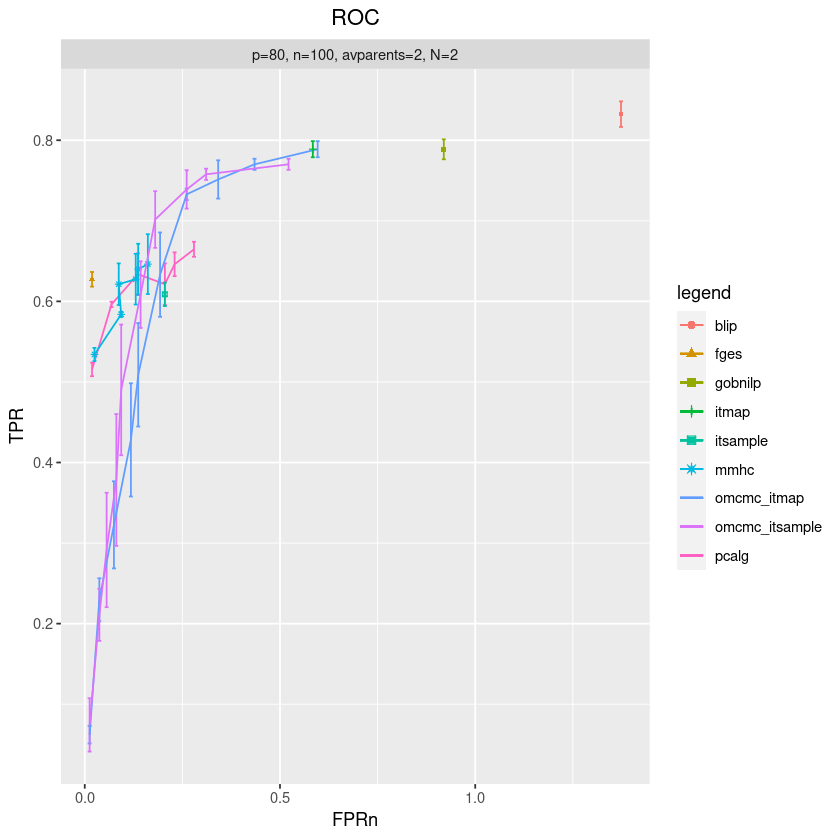

In [678]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
 #geom_text(data = sum_roc_pcalg,
 #           aes(x = FPRn_median, 
 #               y = TPR_q3,               
 #               label=alpha, col=legend),
 #         check_overlap = TRUE,
 #          nudge_x=-0.02,
 #         nudge_y=0.02
 #         ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=legend),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = legend, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = legend), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = legend)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = legend, 
               shape = legend), 
               size = 1) +
# Gobnilp
 geom_errorbar(data = sum_roc_gobnilp,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_gobnilp,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# FGES
 geom_errorbar(data = sum_roc_fges,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = legend), 
               width = 0.01) +
 geom_path(data = sum_roc_fges,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = legend)) +
 geom_point(data = sum_roc_fges,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = legend, 
                shape = legend), 
                size = 1) +
# Subplot
# 

# put full label in the dataframe and save it as label.
# then write  facet_wrap(. ~ label)

#facet_wrap(. ~ dim + avparents + sample_size + N, scales="free_x", nrow = 2) +
facet_wrap(. ~ labels, scales="free_x", nrow = 2) +

# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

In [ ]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_mmhc,
#          aes(x = algorithm, 
#               y = SHD_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = SHD_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 15), legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_x") +
#ylab("Mean SHD") +
#xlab("Algorithm") 
#ggsave(file=file.path("SHD.eps"))

## Logscores

In [ ]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_text(data = sumROC_order_mcmc,
#          aes(x = algorithm, 
#               y = logscore_mean,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10),
#      legend.position = "none") +
#facet_wrap(. ~ labels, scales="free_y") +
#ylab("Mean log-score") +
#xlab("Algorithm") +
#ggsave(file=file.path("logscore.eps"))


## Times

In [ ]:
#ggplot() + 
#geom_point(data = sumROC_order_mcmc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_text(data = sum_roc_pcalg,
#          aes(x = algorithm, 
#               y = time_mean,               
#                col = algorithm, label=alpha),
#            check_overlap = TRUE,
#           nudge_x=0.2,
#          nudge_y=0.9) +

#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_blip,
#          aes(x = algorithm,
#              y = time_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_itsearch,
#          aes(x = algorithm,
#              y = time_mean,
#             col = algorithm)) +
#theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
#facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
#ylab("Mean run time (s)") +
#xlab("Algorithm") 
#ggsave(file=file.path("runtimes.eps"))